## Import Libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import os
from itertools import chain

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# import transform_fns as trans
import pdm_functions as fns
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.stats import gaussian_kde

import pickle



## Weight계산 

In [2]:
df_normal= pd.read_csv('../dataset/5528_spec_normal.csv')
df_error= pd.read_csv('../dataset/5528_spec_error.csv')

In [3]:
df_normal['spectrum_x_amp']= df_normal['spectrum_x_amp'].apply(lambda x: [float(num) for num in x.split(',')][1:])

In [4]:
wf = fns.rpm_approx_weighted_fn(df_normal['spectrum_x_amp'], 1, 2048, 2048)

### <span style='color:red'> 가중치 standardization </span>

In [5]:
# wf = fns.min_max_standardization(wf)

In [6]:
wf = wf * 36
wf = torch.tensor(wf)

## 데이터셋 (tensors)

In [7]:
df_normal = fns.csv_to_tensor_stack('../dataset/5528_spec_normal.csv')
df_error = fns.csv_to_tensor_stack('../dataset/5528_spec_error.csv')

## 데이터셋에 가중치 곱하기

In [8]:
df_normal.shape
wf.shape
df_normal = df_normal * wf
df_error = df_error * wf

## 데이터셋 숫자 늘리기
### <span style='color:red'> 몇 배로 데이터를 늘릴 것인가 multi_dim </span>

In [ ]:
df_normal_aug = fns.multi_datasets(df_normal, multi_dim=300)


In [ ]:
df_error_aug = fns.multi_datasets(df_error, multi_dim= 3300)


In [ ]:
print(df_normal_aug.shape, df_error_aug.shape)

In [74]:
X_train, X_test, y_train, y_test= fns.binary_labeling(df_normal_aug, df_error_aug, test_size=.2, random_state=42 )

## 데이터 상위 x개 추출
### <span style='color:red'> get_sorted_top_k_values(data, k = 5000)</span>

In [75]:
X_train = fns.get_sorted_top_k_values(X_train, 5000)

In [76]:
X_train.shape, y_train.shape

(torch.Size([8520, 5000]), torch.Size([8520]))

### <span style="color:red"> Input값이 너무 작을 경우 곱셈으로 늘려준다 (예: * 1000)  </span>

In [77]:
train_x = fns.get_sorted_top_k_values(X_train) * 100000

In [78]:
test_x = fns.get_sorted_top_k_values(X_test) * 100000

<Axes: >

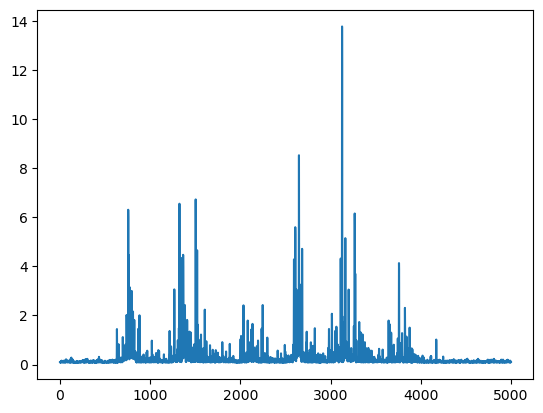

In [79]:
sns.lineplot(train_x[0])

<Axes: >

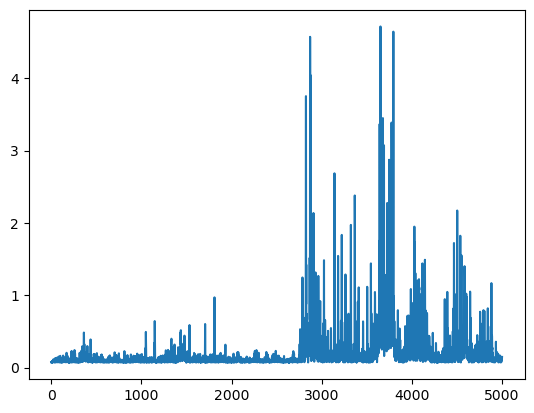

In [80]:
sns.lineplot(test_x[3])

In [81]:
train_label = y_train
test_label = y_test

In [82]:
train_x.shape, train_label.shape

(torch.Size([8520, 5000]), torch.Size([8520]))

In [83]:
test_x.shape, test_label.shape

(torch.Size([2130, 5000]), torch.Size([2130]))

In [84]:
train_dataset = TensorDataset(train_x, train_label)

In [85]:
test_dataset = TensorDataset(test_x, test_label)

In [86]:
dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [87]:
dataloader_test =DataLoader(test_dataset, batch_size= 128, shuffle=True)

## Model Structure
### <span style='color:red'> 모델 시퀀스 </span>

In [88]:
learning_rate = 0.001
num_epochs = 25

model = nn.Sequential(    
    nn.Conv1d(in_channels=1, out_channels=16, kernel_size=2, stride=2, padding=0),  
    nn.ReLU(), 
    nn.MaxPool1d(kernel_size=2),  
    nn.Conv1d(in_channels=16, out_channels=32, kernel_size=2, stride=2, padding=0),  
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(32 * 312 , 64), 
    nn.ReLU(),
    nn.Linear(64, 2)  
)

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [89]:
print(model)

Sequential(
  (0): Conv1d(1, 16, kernel_size=(2,), stride=(2,))
  (1): ReLU()
  (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(16, 32, kernel_size=(2,), stride=(2,))
  (4): ReLU()
  (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=9984, out_features=64, bias=True)
  (8): ReLU()
  (9): Linear(in_features=64, out_features=2, bias=True)
)


### Model Training

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for x_batch, labels in dataloader:
        optimizer.zero_grad()

        # Reshape x_batch to have one input channel
        x_batch = x_batch.unsqueeze(1)  # Reshape: (batch_size, 1, 5000)
        x_batch = x_batch.to(device)  # Move x_batch to device
        labels = labels.to(device)  # Move labels to device
        
        outputs = model(x_batch)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

cuda
Epoch [1/25], Loss: 0.6446
Epoch [2/25], Loss: 0.5430
Epoch [3/25], Loss: 0.4796
Epoch [4/25], Loss: 0.4176
Epoch [5/25], Loss: 0.3442
Epoch [6/25], Loss: 0.2741
Epoch [7/25], Loss: 0.2100
Epoch [8/25], Loss: 0.1618
Epoch [9/25], Loss: 0.1172
Epoch [10/25], Loss: 0.0909
Epoch [11/25], Loss: 0.0702
Epoch [12/25], Loss: 0.0548
Epoch [13/25], Loss: 0.0499
Epoch [14/25], Loss: 0.0447
Epoch [15/25], Loss: 0.0377
Epoch [16/25], Loss: 0.0333
Epoch [17/25], Loss: 0.0368
Epoch [18/25], Loss: 0.0863
Epoch [19/25], Loss: 0.0500
Epoch [20/25], Loss: 0.0301
Epoch [21/25], Loss: 0.0226
Epoch [22/25], Loss: 0.0229
Epoch [23/25], Loss: 0.0184
Epoch [24/25], Loss: 0.0184
Epoch [25/25], Loss: 0.0146


## Model Evaluation

In [91]:
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

# Initialize variables to keep track of the loss and predictions
total_loss = 0.0
all_labels = []
all_predictions = []

with torch.no_grad():
    for x_batch, labels in dataloader_test:  # Assuming you have a separate validation or test DataLoader
        # Reshape x_batch to have one input channel
        x_batch = x_batch.unsqueeze(1)  # Reshape: (batch_size, 1, 5000)
        x_batch = x_batch.to(device)  # Move x_batch to device
        labels = labels.to(device)
        
        outputs = model(x_batch)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        
        total_loss += loss.item()  # Accumulate the loss
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
        
        all_labels.extend(labels.cpu().numpy())  # Store true labels
        all_predictions.extend(predicted.cpu().numpy())  # Store predicted labels

# Calculate average loss
avg_loss = total_loss / len(dataloader)

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions, average='weighted')  # Use 'micro' or 'macro' if needed
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# Print results
print(f"Evaluation Loss: {avg_loss:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
# print(all_labels)
# print(all_predictions)

cuda
Evaluation Loss: 0.2873
Precision: 0.8067, Recall: 0.8066, F1 Score: 0.8066


## 모델 저장

In [92]:
torch.save(model, 'model_v0.0.3.pth')